In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="stochastic")
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic")

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)

Simulation Progress: 100%|██████████| 5000/5000 [00:11<00:00, 439.00it/s, avg reward=0.007975]


In [ ]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 5e-4,
    'eta': 0.1,
    'N_action_candidates': 50
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env,
    clonePolicy=True,
    epochs=200, 
    batch_size=512,
    updateCriticOnly=False)

Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 79.13it/s]                                       


Epoch   20/ 200  Avg Ld=0.501252  Avg Lq=-0.682576  Avg loss_critic=0.526601  Test packet loss=0.0311


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 79.31it/s]                                       


Epoch   40/ 200  Avg Ld=0.167217  Avg Lq=-1.684438  Avg loss_critic=0.028403  Test packet loss=0.0050


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 72.02it/s]                                       


Epoch   60/ 200  Avg Ld=0.133450  Avg Lq=-3.092130  Avg loss_critic=0.041068  Test packet loss=0.0056


Evaluation windows: 100%|██████████| 500/500 [00:07<00:00, 67.85it/s]                                       


Epoch   80/ 200  Avg Ld=0.119751  Avg Lq=-4.554972  Avg loss_critic=0.077446  Test packet loss=0.0059


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 80.26it/s]                                        


Epoch  100/ 200  Avg Ld=0.111946  Avg Lq=-5.986768  Avg loss_critic=0.113219  Test packet loss=0.0046


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 80.04it/s]                                        


Epoch  120/ 200  Avg Ld=0.104275  Avg Lq=-7.414658  Avg loss_critic=0.163359  Test packet loss=0.0061


Evaluation windows: 100%|██████████| 500/500 [00:08<00:00, 57.12it/s]                                        


Epoch  140/ 200  Avg Ld=0.095487  Avg Lq=-8.899106  Avg loss_critic=0.249314  Test packet loss=0.0057


Epoch 157/200:  84%|████████▍ | 16/19 [00:00<00:00, 31.30batch/s, Ld=0.087653, Lq=-10.777312, critic=0.265908]

In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


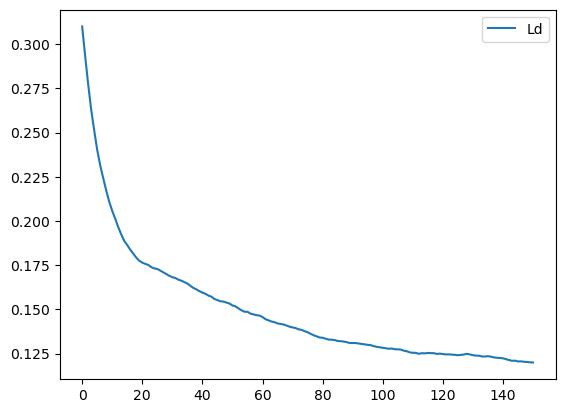

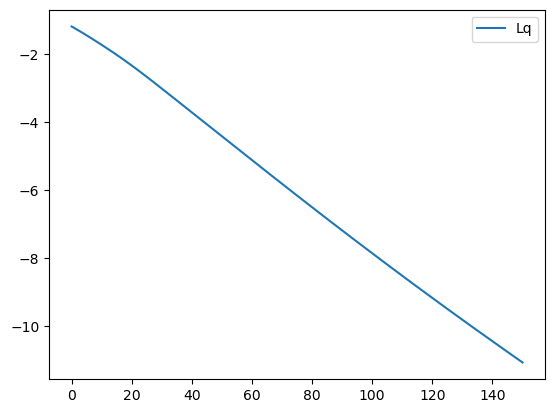

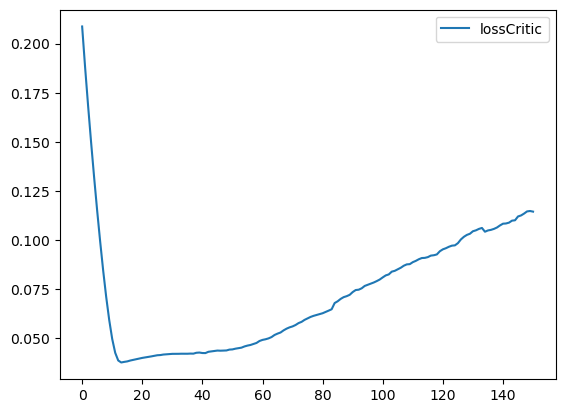

In [ ]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 50
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()